<a href="https://colab.research.google.com/github/luisERH/NER_Twitter/blob/main/Desafio_AEVO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NER em tweets em português do Brasil
**Conteúdo**

Um conjunto de dados para reconhecimento de entidade nomeada em tweets (português do Brasil)


**Dados**

*   Treino - exemplos de 3,6k (dataset.ptbr.twitter.train.ner)
*   Teste - 900 exemplos (dataset.ptbr.twitter.test.ner)

**Como usá-lo?**

Para cumprir os Termos de Serviço do Twitter, apenas IDs de tweet são fornecidos. Para baixar os tweets completos correspondentes usando suas próprias credenciais de API do Twitter. A primeira linha ("tweet id inicial pos final pos nomeado entity_type") do arquivo é adicionada para especificar as informações acima sobre as anotações, portanto, não faz parte das anotações reais


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [2]:
!pip install spacy --upgrade -q
!python -m spacy download pt -q # Pacote em Portugês
!pip install gspread-pandas -q
!pip install spacy-lookups-data -q
!pip install ipython-autotime -q

     |████████████████████████████████| 10.4MB 5.4MB/s 
     |████████████████████████████████| 1.1MB 53.3MB/s 
     |████████████████████████████████| 19.6MB 1.2MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')
     |████████████████████████████████| 93.8MB 42kB/s 


In [12]:
from IPython.display import clear_output
from spacy.util import minibatch, compounding
from IPython.display import display,HTML
from spacy import displacy, load
import random
from pathlib import Path
import spacy
import re,unicodedata
from json import load
import time
import pandas as pd
import tweepy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pln = spacy.load('pt')

%load_ext autotime 

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.96 s


# Etapa 1: Aquisição de dados


In [5]:
! pip install ipython-autotime # para exibir o tempo de execução de cada célula
! pip install --upgrade  kaggle # importando a ultima versão 
! mkdir ~/.kaggle # criando diretório para credencial na raiz
! cp '/content/drive/My Drive/Colab Notebooks/creds/kaggle.json' ~/.kaggle/ #copiando minha credencial do kaggle para raiz
! kaggle datasets download -d rafaelperes/ner-in-brazilian-portuguese-tweets # dowload do dataset

!unzip /content/ner-in-brazilian-portuguese-tweets.zip -d ./dataset #Descompactação
!rm /content/ner-in-brazilian-portuguese-tweets.zip 

clear_output() #limpa o output

time: 6.41 s


#Pré-processamento e Processamento dos dados



>  **OBS*** Para o Reconheceimento de entidades Nomeadas, optei por não fazer o pré-processamento completo (como Stemização, remoção de stop words, padronização...), como utilizei a ferramente Spacy, estes processos acabam interferindo no comprimento das strings, e até mesmo a padronização de deixar em lowercase interfere no reconhecimento das entidades, então para este caso somente adaptei a base para o padrão exigido pelo Spacy.



# Visualização dos dados

In [6]:
def multi_column_df_display(list_dfs, cols=2): #Somente perfumaria (exibe dataframes um ao lado do outro)
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)

    cells = [ html_cell.format(content=df.to_html()) for df in list_dfs ]
    cells += (cols - (len(list_dfs)%cols)) * [html_cell.format(content="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))

time: 13.9 ms


## Carregamento das bases

In [10]:
df_train = pd.read_table('/content/dataset/dataset.ptbr.twitter.train.ner').set_index('tweet_id',drop=True) 
df_test = pd.read_table('/content/dataset/dataset.ptbr.twitter.test.ner').set_index('tweet_id',drop=True)
multi_column_df_display([df_test.head(), df_train.head()])
print(20*' ','Treinamento',100*' ','Teste')

,start_pos,end_pos,named_entity_type
tweet_id,,,
854831714446737408,0,0,No entities found in this tweet
854831714400706560,0,0,No entities found in this tweet
854831714337787905,0,0,No entities found in this tweet
854831714002100224,0,0,No entities found in this tweet
854831713637330944,0,0,No entities found in this tweet
,start_pos,end_pos,named_entity_type
tweet_id,,,
853794876961456128,0,0,No entities found in this tweet
853794875590021121,0,0,No entities found in this tweet


                     Treinamento                                                                                                      Teste
time: 21.5 ms


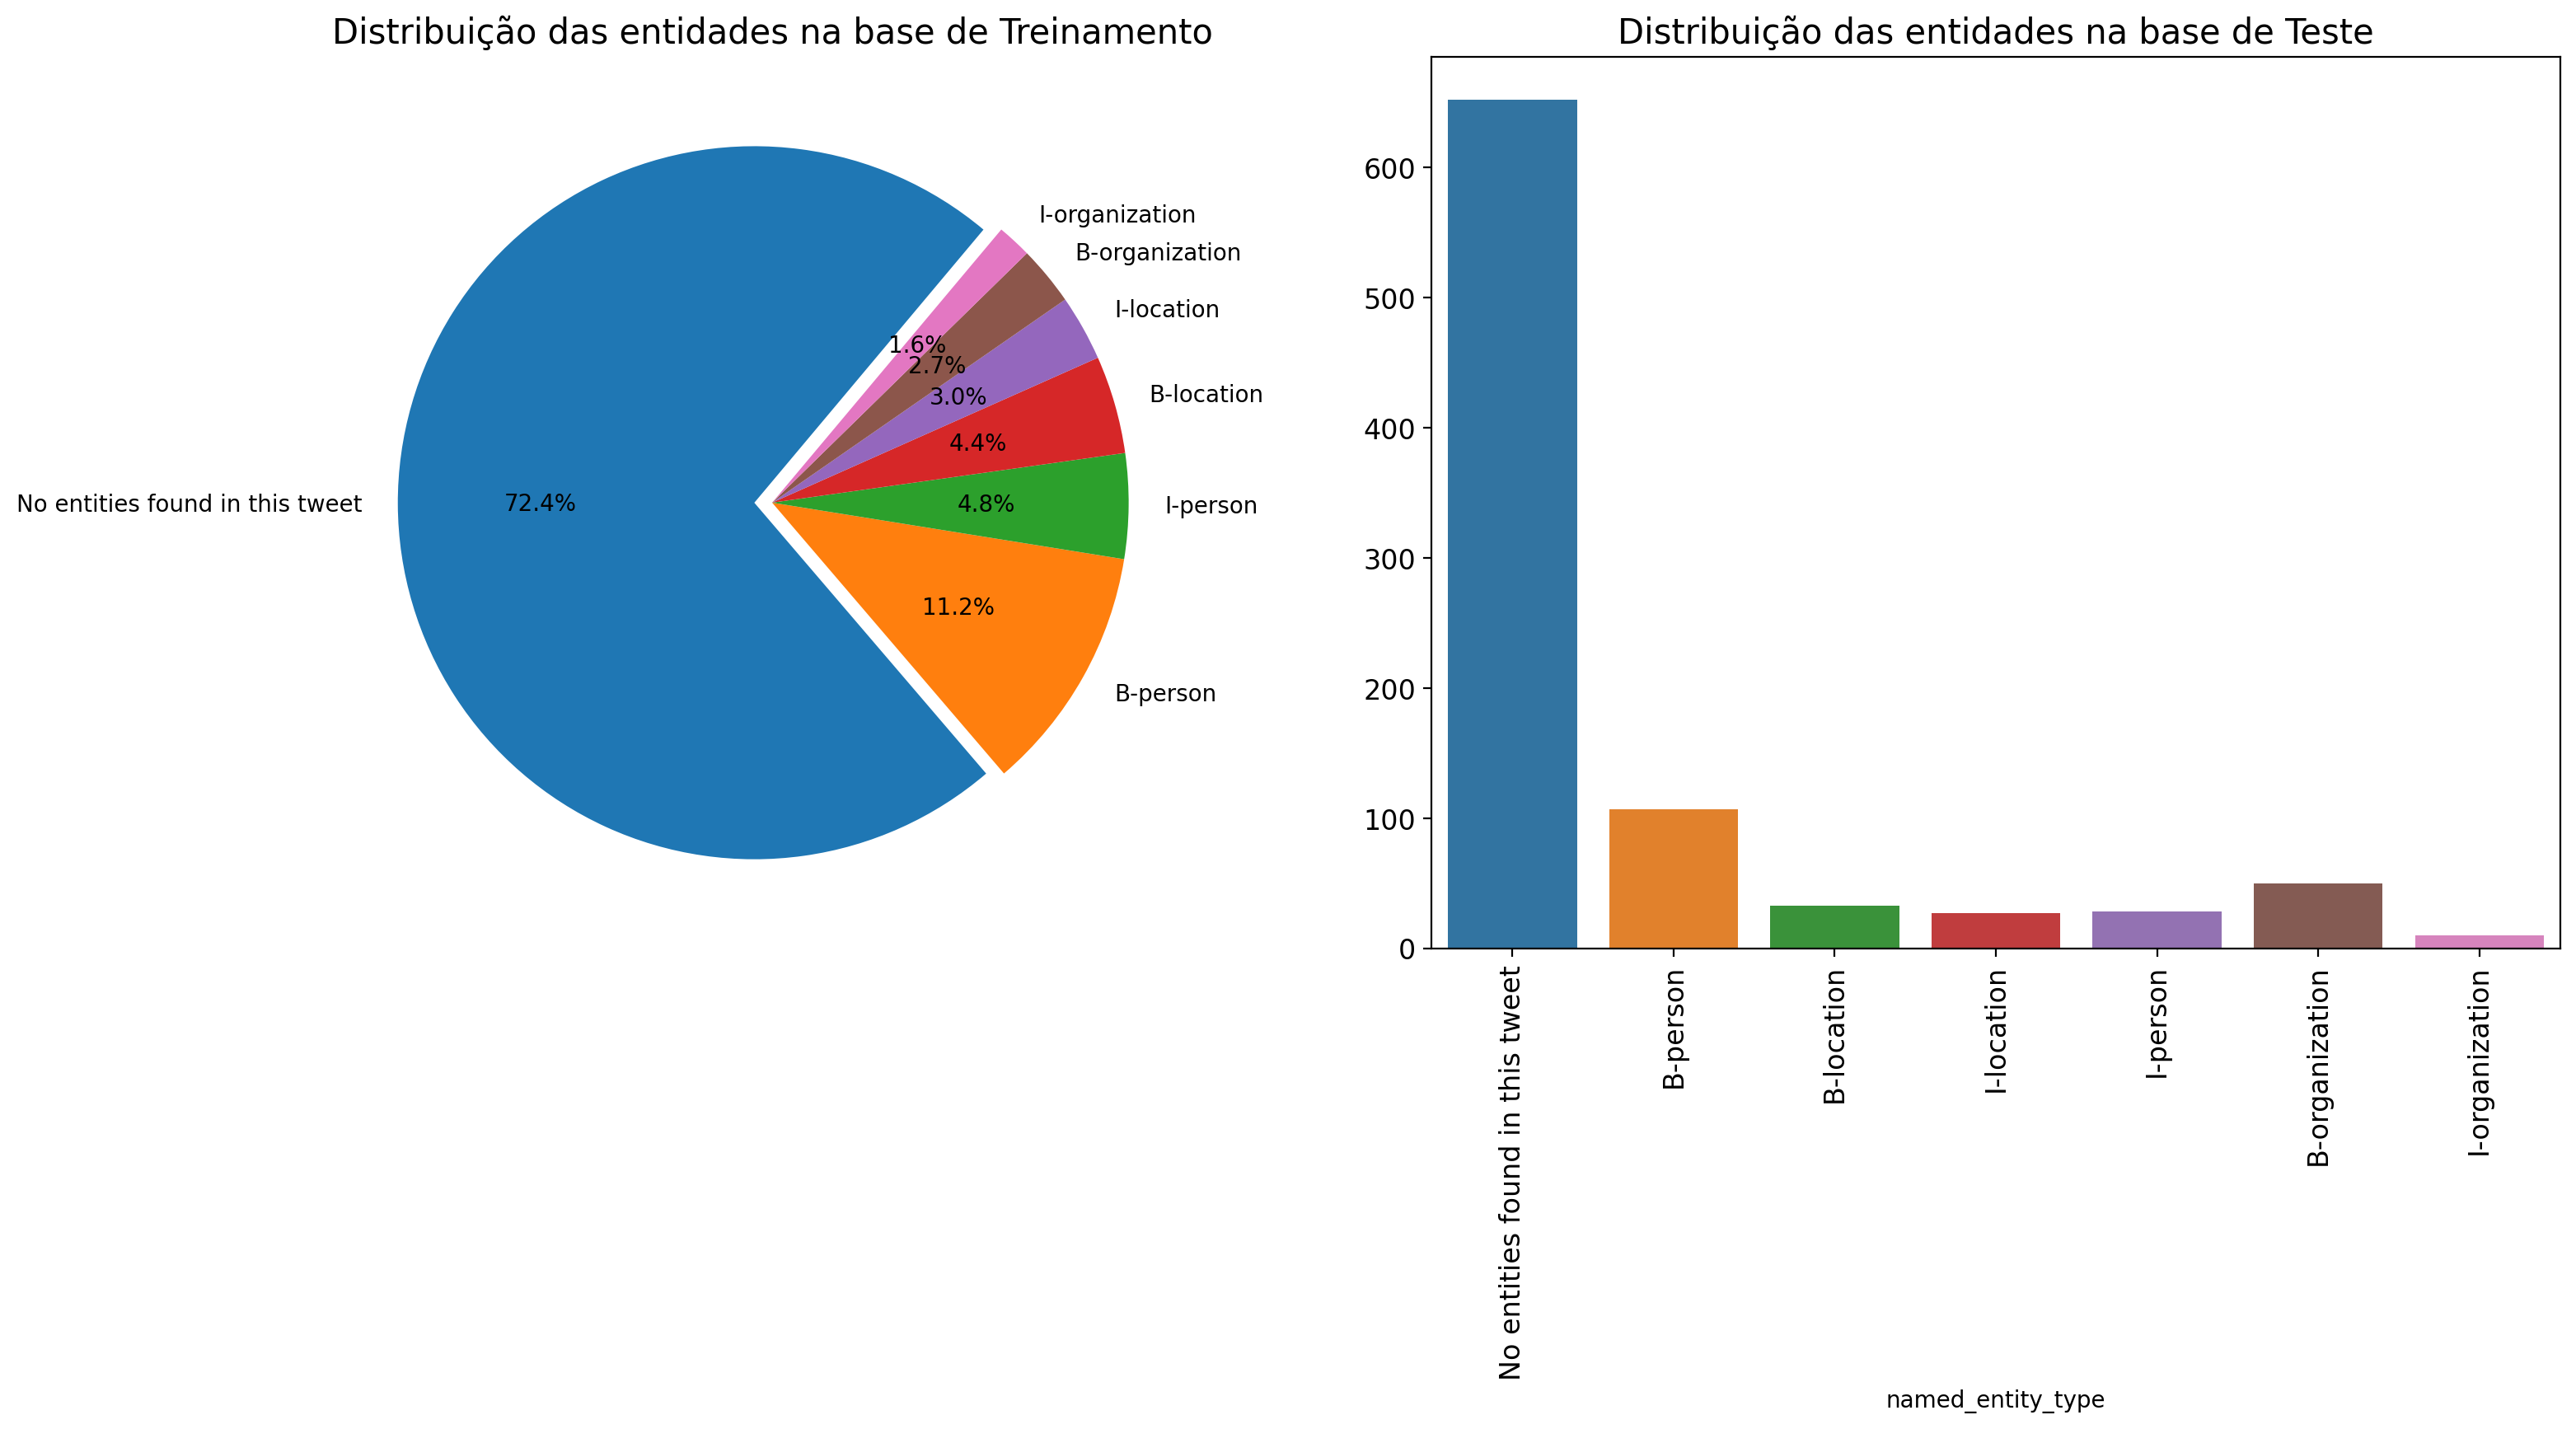

,named_entity_type
No entities found in this tweet,2644
B-person,409
B-organization,174
B-location,162
I-person,109
I-location,98
I-organization,57
,Test
No entities found in this tweet,652
B-person,107


time: 1.07 s


In [13]:
plt.rcParams['axes.edgecolor']='#000'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#000'
plt.rcParams['ytick.color']='#000'


fig, axes = plt.subplots(ncols=2, figsize=(15, 6), dpi=200)
plt.tight_layout()
proporcoes_train = df_train.named_entity_type.value_counts()
labels_train = df_train.named_entity_type.unique()

sns.countplot(x = 'named_entity_type',data= df_test, ax=axes[1])
axes[0].pie(proporcoes_train.array, explode=(0.05, 0, 0, 0,0,0,0) , labels=labels_train, autopct='%1.1f%%', startangle=50)
axes[0].set_ylabel('')
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title('Distribuição das entidades na base de Treinamento', fontsize=15)


axes[1].set_ylabel('')
axes[1].tick_params(axis='x', labelsize=12,rotation=90)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title('Distribuição das entidades na base de Teste', fontsize=15)
plt.show()
multi_column_df_display([pd.DataFrame(df_train.named_entity_type.value_counts()).rename({'': 'Train'}, axis=1),
                         pd.DataFrame(df_test.named_entity_type.value_counts()).rename({'named_entity_type': 'Test'}, axis=1)])

##Credenciamento para uso da API do Twitter

In [14]:
consumer_key = "xxxxxxxxxxxxxxxxxxxxxxxx"
consumer_secret = "xxxxxxxxxxxxxxxxxxxxxxxx"
access_token = "xxxxxxxxxxxxxxxxxxxxxxxx"
access_token_secret = "xxxxxxxxxxxxxxxxxxxxxxxx"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

time: 6.47 ms


### Problamas Encontrados:


*   Recuperação Tweets: De 3653 tweets, somente 1992 podem ser recuperados pela API.

*   Limite de Requisições: solução foi fazer requisições em batchs de aproximadamente 100, com tempo de delay.
 




In [15]:
def build_dataframe(tweet_ids):
    df = pd.DataFrame()
    
    for batch in np.array_split(tweet_ids, (len(tweet_ids)/99)):
        tweets = api.statuses_lookup(id_= batch.tolist(), include_entities=False, trim_user=True)
        if len( batch.tolist()) != len(tweets):
            print('get_tweet_list: Foram encontrados {} de {} tweets'.format(len(tweets), len( batch.tolist())))

        for tweet in tweets:
            df = df.append(pd.json_normalize(tweet._json))
        time.sleep(1)

    return df
    
tweet_ids_train = df_train.index
print('Aquisição de tweets na base de Treinamento:\n')
df2_train =  build_dataframe(tweet_ids_train)

tweet_ids_test = df_test.index

print('\nAquisição de tweets na base de Teste:\n')
df2_test = build_dataframe(tweet_ids_test)

Aquisição de tweets na base de Treinamento:

get_tweet_list: Foram encontrados 68 de 102 tweets
get_tweet_list: Foram encontrados 56 de 102 tweets
get_tweet_list: Foram encontrados 58 de 102 tweets
get_tweet_list: Foram encontrados 55 de 102 tweets
get_tweet_list: Foram encontrados 57 de 102 tweets
get_tweet_list: Foram encontrados 65 de 102 tweets
get_tweet_list: Foram encontrados 62 de 102 tweets
get_tweet_list: Foram encontrados 54 de 102 tweets
get_tweet_list: Foram encontrados 55 de 102 tweets
get_tweet_list: Foram encontrados 61 de 102 tweets
get_tweet_list: Foram encontrados 53 de 102 tweets
get_tweet_list: Foram encontrados 56 de 102 tweets
get_tweet_list: Foram encontrados 57 de 102 tweets
get_tweet_list: Foram encontrados 63 de 102 tweets
get_tweet_list: Foram encontrados 50 de 102 tweets
get_tweet_list: Foram encontrados 54 de 102 tweets
get_tweet_list: Foram encontrados 62 de 102 tweets
get_tweet_list: Foram encontrados 55 de 101 tweets
get_tweet_list: Foram encontrados 60 

> **Após a extração, foi feito a intercessão entre a base de dados original e a que foi extraída com êxito pela API do Twitter.**

In [16]:
df2_train  = df2_train[['id','created_at','text','lang',]].drop_duplicates().set_index('id',drop=True)
df2_test  = df2_test[['id','created_at','text','lang',]].drop_duplicates().set_index('id',drop=True)

pd.merge(df_train, df2_train, left_index=True, right_index=True).to_excel('/content/drive/MyDrive/Colab Notebooks/AEVO/train.xlsx')
pd.merge(df_train, df2_train, left_index=True, right_index=True).to_excel('/content/drive/MyDrive/Colab Notebooks/AEVO/test.xlsx')

time: 1.82 s




> Recuperando a base que foi salva no Google Drive.





In [21]:
df2_train = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/AEVO/train.xlsx',index_col=0) #.set_index('id',drop=True)
df2_test = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/AEVO/test.xlsx',index_col=0) #.set_index('id',drop=True)

df2_train['created_at'] = df2_train['created_at'].apply(lambda x: tweepy.utils.parse_datetime(x)) 
df2_test['created_at'] = df2_test['created_at'].apply(lambda x: tweepy.utils.parse_datetime(x)) 


time: 332 ms


In [24]:
DATASET_NER = {}
for ind in df2_train.index:
    try:
        DATASET_NER.update({ind: [df2_train.loc[[ind]].iloc[0]['text'], {'entities': []} ]})
        for i in df_train.loc[[ind]].itertuples():
            try:
                if i.start_pos != 0 and  i.end_pos != 0:
                    DATASET_NER[ind][1]['entities'].append([i.start_pos-1, i.end_pos-1,i.named_entity_type])
            except: continue
    except: continue
        # print(df2_train.loc[[ind]].iloc[0]['text'],i.start_pos-1, i.end_pos-1,i.named_entity_type)

time: 4.55 s


In [27]:
TRAIN_DATA = []
for i in DATASET_NER:
    TRAIN_DATA.append(DATASET_NER[i])

for i,j in TRAIN_DATA:
    j['entities'] = pd.DataFrame(j['entities']).drop_duplicates().values.tolist()

time: 870 ms




> Treinando um Modelo NER do zero.



In [28]:
model=None
output_dir=Path("/content/")
n_iter=50

if model is not None:
    nlp = spacy.load(model)  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank("pt")  # create blank Language class
    print("Created blank 'pt' model")

if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe("ner")

Created blank 'pt' model
time: 3.21 s


In [29]:
nlp.vocab.vectors.name = 'spacy_trained_vectors'
for _, annotations in TRAIN_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

time: 5.45 ms


In [30]:
with nlp.disable_pipes(*other_pipes):  # only train NER
    optimizer=nlp.begin_training()
    for epoch,itn in enumerate(range(n_iter)):
        try:
            random.shuffle(TRAIN_DATA)
            losses = {}
                # batch up the examples using spaCy's minibatch
            batches = minibatch(TRAIN_DATA, size=compounding(4., 32., 1.001))
            for text, annotations in (TRAIN_DATA):
                nlp.update(
                    [text],
                    [annotations],
                    sgd=optimizer,
                    drop=0.37,
                    losses=losses)
            print("Epoch:",epoch+1," Loss:", losses['ner'])
        except:
            raise
            continue     

/usr/local/lib/python3.6/dist-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text ""Nunca se queime por alguém que nunca se esquentou..." with entities "[[71, 78, 'B-person'], [79, 86, 'I-person']]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/usr/local/lib/python3.6/dist-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "“cxs2” está previsto art. 1º da Lei 8.137/90. O qu..." with entities "[[131, 134, 'B-organization']]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/usr/local/lib/python3.6/dist-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned i

Epoch: 1  Loss: 848.9747656538444
Epoch: 2  Loss: 754.7094632971064
Epoch: 3  Loss: 727.3759344592095
Epoch: 4  Loss: 734.7669999996888
Epoch: 5  Loss: 696.3779173385515
Epoch: 6  Loss: 681.9541051772554
Epoch: 7  Loss: 573.5157548271222
Epoch: 8  Loss: 572.958190684056
Epoch: 9  Loss: 532.2008014574451
Epoch: 10  Loss: 459.3229833681885
Epoch: 11  Loss: 429.1308172495175
Epoch: 12  Loss: 390.52411017287807
Epoch: 13  Loss: 368.9157618139511
Epoch: 14  Loss: 306.96097782734313
Epoch: 15  Loss: 297.991723617927
Epoch: 16  Loss: 257.53987510125694
Epoch: 17  Loss: 228.16903894844697
Epoch: 18  Loss: 206.14558928161057
Epoch: 19  Loss: 217.31987091774076
Epoch: 20  Loss: 194.41204977093486
Epoch: 21  Loss: 176.66511703151548
Epoch: 22  Loss: 151.08529201783577
Epoch: 23  Loss: 175.28071523407266
Epoch: 24  Loss: 144.07656104316538
Epoch: 25  Loss: 199.14089481926754
Epoch: 26  Loss: 143.36101042841395
Epoch: 27  Loss: 114.49423238432263
Epoch: 28  Loss: 122.13618359918621
Epoch: 29  Loss:

In [31]:
if output_dir is not None:
    output_dir = Path(output_dir)
    if not output_dir.exists():
        output_dir.mkdir()
    nlp.to_disk('/content/model')
    print("Saved model to", output_dir)

!zip -r /content/model.zip  /content/model -q

Saved model to /content
time: 342 ms


In [36]:
nlp3=spacy.load('/content/model')

colors = {"B-PERSON": "linear-gradient(90deg, #aa9cfc, #aa9fff)",
          "B-LOCATION": "linear-gradient(90deg, #cc85a1, #bbcc8)",
          "I-LOCATION": "linear-gradient(90deg, #dd85a1, #dd88)",
          "B-ORGANIZATION": "linear-gradient(90deg, #ee85a1, #ee88f8)",
          "I-ORGANIZATION": "linear-gradient(90deg, #ff85a1, #ff8888)",
          "I-PERSON": "linear-gradient(90deg, #2485a1, #448888)"}
options = {"colors": colors}

time: 7.12 s


# Apresentação dos resultados




> **OBS*** Não foi possível fazer uma boa apresentação e avaliação do modelo, pois grande parte dos registros da base de teste não foram recuperados, entretando apliquei o modelo e retratei em alguns testes com a ferramenta visual do Spacy.




In [38]:
for i , row in  df2_test.iterrows():
    canhoto=nlp(row.text)
    if canhoto.ents:
       displacy.render(canhoto, style="ent",jupyter="True",options=options)
       print(150*'-')


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------
time: 9.3 s


In [39]:
!cp '/content/model.zip' '/content/drive/MyDrive/Colab Notebooks/AEVO/'

time: 138 ms
